In [ ]:
%config IPCompleter.greedy=True

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Final Introduction to AI course : COVID-19 Analysis and Predictions

## Introduction: Dataset

Authors of the dataset: 
Xu, Bo and Gutierrez, Bernardo and Mekaru, Sumiko and Sewalk, Kara and Goodwin, Lauren and Loskill, Alyssa and  Cohn, Emily and Hswen, Yulin and Hill, Sarah C. and Cobo, Maria M and Zarebski, Alexander and Li, Sabrina and Wu, Chieh-Hsi   and Hulland, Erin and Morgan, Julia and Wang, Lin and O'Brien, Katelynn and Scarpino, Samuel V. and Brownstein, John S. and Pybus, Oliver G. and Pigott, David M. and Kraemer, Moritz U. G.

Article about the dataset: [Epidemiological data from the COVID-19 outbreak, real-time case information}](https://www.doi.org/10.1038/s41597-020-0448-0)

Github : https://github.com/beoutbreakprepared/nCoV2019

In [ ]:
#path = ('https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/outside_hubei_20200301.csv')
path = "latestdata.csv"

df = pd.read_csv(path)
df.head()

In [ ]:
df.columns

In [ ]:
df.describe(include="all")

# 0. Cleaning Dataset


## Age Range to average age conversion

Some of the ages are actually an age range. The goal here if to convert some age ranges to an average age.

_ex: 10-20 => 15_

In [ ]:
df = df[df["age"] != "7 months"]

tmp = []

for index,value in enumerate(df["age"]): 
    try:
        if (type(value) == str):
            # some age values may be a range like : "12-20"
            age_array = value.split("-")
            if len(age_array) == 2:
                tmp.append((float(age_array[0]) + float(age_array[1])) // 2)
            else: 
                tmp.append(float(value))
        else:
            tmp.append(float(value))
    except Exception:
        tmp.append(np.NaN)
        continue

ages_transformed = pd.Series(tmp)

In [ ]:
df["age"] = ages_transformed

## Outcome standarzing

The outcome types are of types :
- 'death'
- 'discharge'
- 'discharged'
- 'Discharged'
- 'recovered',
- 'dead'
- 'died'
- 'Died'

If the person died the value will be _1_ and will be _0_ if recovered/dismissed.



In [ ]:
tmp = []

for value in df["outcome"]:
    if type(value) == str:
        lowered_value = value.lower()
        if lowered_value in ["dead", "died","death"]:
            tmp.append(1)
        else:
            tmp.append(0)
    else:
        tmp.append(0)
    
outcome_standardized = pd.Series(tmp)


In [ ]:
df["outcome"] = outcome_standardized

## Droping null and NaN values

In [ ]:
df = df.dropna(subset=["age", "sex","city", "outcome", "country", "province"])

In [ ]:
df.shape

## Country, City, Province Standardizing

Countries are string values, for modeling and analysis  we will associate the variables to labels  

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df["country"])

df["country_code"] = le.transform(df["country"])

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df["province"])

df["province_code"] = le.transform(df["province"])

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df["city"])

df["city_code"] = le.transform(df["city"])

## Standardizing Sex

Male will be considered 1 and female will be considered 0.

In [ ]:
df["sex"].unique()

In [ ]:
df["sex"].isna().sum()

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df["sex"])

df["sex_code"] = le.transform(df["sex"])

## Cleaning Age

Ages need to be between 1 and 130 years old and be labelled a category

In [ ]:
df = df[(df["age"] <= 130) & (df["age"] > 0)]

In [ ]:
age_groups = pd.cut(df["age"],bins=[0,2,17,65,130],labels=['Toddler/Baby','Child','Adult','Elderly'])
df["age_group"] = age_groups


In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df["age_group"])

df["age_group_code"] = le.transform(df["age_group"])

# 1. Analysis of the Dataset

Number of people in "cleaned" dataset 

In [ ]:
df.shape[0]

Total number of deaths in dataset

In [ ]:
df["outcome"].sum()

Number of deaths per age group and sex

In [ ]:
df.pivot_table("outcome", index="sex", columns="age_group", aggfunc="sum")

Correlation matrix

## A. Variable correlation

In [ ]:
import seaborn as sn

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

The most correlated variables to the outcome is the chronic_disease feature.

This correlation matrix doesn't show any other notable correlation between the outcome and another feature.

## B. Plotting Cleaned Dataset using PCA

In [ ]:
df_trimmed = df.drop(columns=["age_group", "country", "date_onset_symptoms","city", "province",
                     "date_death_or_discharge","notes_for_discussion","location","notes_for_discussion",
                     "ID", "geo_resolution", "date_onset_symptoms", "data_moderator_initials","travel_history_dates","date_confirmation", "travel_history_binary",
                    "country_new", "city","chronic_disease", "additional_information","source", "sequence_available","reported_market_exposure","date_admission_hospital", "symptoms", "travel_history_location",
                    "lives_in_Wuhan", "admin3", "admin2", "sex","admin1","admin_id", "latitude","province_code", "age_group_code","longitude",
                             "country_code","city_code"])

df_trimmed.head()

In [ ]:
from sklearn import decomposition

Y = df_trimmed["outcome"].values
X = df_trimmed.drop(columns=["outcome"]).values # Droping useless columns (for this PCA)

pca = decomposition.PCA(n_components=2)

In [ ]:
pca.fit(X)
X_pca = pca.transform(X)
plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], c=Y)
plt.show()

# 2. Bayes Nets 

Bayes Theorem
\begin{equation*}
P(A|B) = \frac{P(B|A) * P(A)}{P(B)}
\end{equation*}

## A. $P( Has Symptoms| Visited Wuhan)$

Question: 
What is the probability for a person to have symptoms of COVID-19
(symptom_onset=date) if this person visited Wuhan (visiting Wuhan = 1) ? Consider
that (symptom_onset=N/A) means that the patient is asymptomatic.

--- 


We are trying to solve:

\begin{equation*}
P(Has Symptoms|Visited Wuhan) = \frac{P(Has Symptoms \cap Visited Wuhan)}{P(Visited Wuhan)}
\end{equation*}




$P(VisitedWuhan)$ : the person visited Wuhan if  the _travel_history_location_ is _Wuhan_.


In [ ]:
total_visited_wuhan = df[df["travel_history_location"] == "Wuhan"]["travel_history_location"].count()
total_history_location = df["travel_history_location"].count() # counting only when the data is about the location is present

p_VisitedWuhan = total_visited_wuhan / total_history_location
p_VisitedWuhan

$P(Has Symptoms \cap Visited Wuhan)$ : the person visited Wuhan if the travel_history_location and is symptomatic

In [ ]:
total = df["date_onset_symptoms"].size
total

In [ ]:
df["date_onset_symptoms"].isnull().sum()

In [ ]:
total_has_symptoms_and_visited_wuhan = df[(df["date_onset_symptoms"].isnull() == False)
                                          & (df["travel_history_location"] == "Wuhan")]["travel_history_location"].count()
total_has_symptoms_and_visited_wuhan

In [ ]:
p_HasSymptomsAndVisitedWuhan = total_has_symptoms_and_visited_wuhan/total
p_HasSymptomsAndVisitedWuhan

$P(Has Symptoms|Visited Wuhan)$ that we can compute from the previous probabilities 


In [ ]:
p_SymptomsKnowingThatVisitedWuhan = p_HasSymptomsAndVisitedWuhan  / p_VisitedWuhan
p_SymptomsKnowingThatVisitedWuhan

To conclude there is roughly 1.1% chance that a person who visited Wuhan has the symptoms. 

## B. $P(Has Symptoms \cap Visited Wuhan)$

What is the probability for a person to be a true patient if this person have symptoms of
COVID-19 (symptom_onset=date) and this person visited Wuhan ?

In [ ]:
p_HasSymptomsAndVisitedWuhan

There is roughly a 0.2% chance that the person has the symptoms and visited Wuhan

## C. $P(Died | Visited Wuhan)$

What is the probability for a person to death if this person visited Wuhan ?

--- 


We are trying to solve:

\begin{equation*}
P(Died|Visited Wuhan) = \frac{P(Died \cap Visited Wuhan)}{P(Visited Wuhan)}
\end{equation*}




$P(Died \cap Visited Wuhan)$ : People who died (outcome = 1.0) and who visited Wuhan.

In [ ]:
total_died_and_visited_wuhan = df[(df["travel_history_location"] == "Wuhan") & (df["outcome"] == 1.0)]["travel_history_location"].count()
p_DiedAndVisitedWuhan = total_died_and_visited_wuhan/total_history_location
p_DiedAndVisitedWuhan

$P(Died|Visited Wuhan)$ : finally we can compute the probability of a person for death if visiting Wuhan. 

In [ ]:
p_DiedKnowingThatVisitedWuhan = p_DiedAndVisitedWuhan / p_VisitedWuhan
p_DiedAndVisitedWuhan

To conclude there is a 0.1% chance that a person dies after visitign Wuhan. 

## D. Average Recovery Interval for a Person visiting Wuhan 

We only keep the people who visited wuhan and recovered from the COVID (outcome = 0.0 and who actually have dates relating to the times of their sickness

In [ ]:
df_visiting_wuhan_not_dead = df.dropna(subset=["date_onset_symptoms","date_death_or_discharge"])
df_visiting_wuhan_not_dead = df_visiting_wuhan_not_dead[(df_visiting_wuhan_not_dead["travel_history_location"] == "Wuhan") & (df_visiting_wuhan_not_dead["outcome"] == 0.0)]


We'll assume $[dateOnsetSymptoms, dateDeathOrDischarge]$ as the interval during which the patient is sick.



In [ ]:
df_visiting_wuhan_not_dead

To facilitate the computation of average recovery time, each date will be computed into seconds.

In [ ]:
from datetime import datetime

computed_row = []

for row in df_visiting_wuhan_not_dead.T.to_dict().values():
    start_date = datetime.strptime(row["date_onset_symptoms"],"%d.%m.%Y").strftime("%s")
    end_date = datetime.strptime(row["date_death_or_discharge"],"%d.%m.%Y").strftime("%s")
    recovery_time = int(end_date) - int(start_date)
    computed_row.append(recovery_time)

df_visiting_wuhan_not_dead["recovery_time"] = computed_row

In [ ]:
average_recovery_seconds = int(df_visiting_wuhan_not_dead["recovery_time"].mean())

In [ ]:
from datetime import timedelta

average_datetime = timedelta(seconds=average_recovery_seconds)
average_datetime

The Average recovery interval a patient who visited Wuhan is 17 days.

# 3. Machine Learning

In [ ]:
to_drop = ['ID','city', 'province', 'country', 'latitude',
           'longitude', 'geo_resolution','reported_market_exposure',
           'additional_information','notes_for_discussion', 'data_moderator_initials',
           'date_onset_symptoms','date_admission_hospital','symptoms','lives_in_Wuhan',
           'travel_history_dates','travel_history_location','chronic_disease','source',
           'sequence_available','date_death_or_discharge',
           'location','admin3','admin2','admin1','travel_history_binary', 'age_group',
          "admin_id", "admin_id", "sex", "date_confirmation", "country_new", "age_group_code", "province_code","city_code" ]
        
df_ml = df.drop(to_drop,axis=1)
df_ml.columns

In [ ]:
df_ml.isna().sum()

 Spliting Data set into train and test

In [ ]:
Y = df_ml["outcome"].values
X = df_ml.drop(columns=["outcome"]).values

 Spliting Data set into train and test

In [ ]:
from sklearn import model_selection

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y,test_size=0.3)

_Normalizing dataset_

In [ ]:
from sklearn import preprocessing

std_scale = preprocessing.StandardScaler().fit(X)
x_train_std = std_scale.transform(x_train)
x_test_std = std_scale.transform(x_test)

 vizualizing un normalized training set

In [ ]:
fig = plt.figure(figsize=(16, 12))
column_names = [col for col in list(df_ml.columns) if col != "outcome"]

for feat_idx in range(x_train_std.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(x_train_std[:, feat_idx], bins=50, color = 'steelblue', density=True, edgecolor='none')
    ax.set_title(column_names[feat_idx], fontsize=14)

## A.Selecting a model

### Computing a baseline

The baseline is a  classiefier model with poor resultats that we will use to give us an idea of what are relatively to our problem poor results.

Here we chose a Dummy Classifier that will always predicts the most frequent class of the dataset (which in our case will be outcome = 0).

In [ ]:
from sklearn.dummy import DummyClassifier 
dum = DummyClassifier(strategy='most_frequent')


dum.fit(x_train_std, y_train)
y_pred_dum = dum.predict(x_test_std)

### Evaluating the baseline

*RMSE*: Root Mean Square Value. Differences between values predicted by a model and the values observed.

\begin{equation*}
rmse = \sqrt{(\frac{1}{n})\sum_{i=1}^{n}(y_{i} - x_{i})^{2}}
\end{equation*}
  

*Acuracy Score*: ratio of number of correct predictions to the total number of input samples. 

In [ ]:
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y_test, y_pred_dum))))
print("Accuracy Score: {:.2f}".format(metrics.accuracy_score(y_test,y_pred_dum)))

*AUC - ROC curve:* performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes.


*AUC*: Area Under The Curve

*ROC*: Receiver Operating Characteristics


*TP*: True Positive

*FP*: False Positive

*FN*: False Negative 

*TN*: True Negative



*True Positive Rate / Recall / Sensitivity*: 
\begin{equation*}
Recall = \frac{TP}{TP+FN}
\end{equation*}

*False Positive Rate*: 
\begin{equation*}
1 - Specificity = 1 - \frac{FP}{TN+FP}
\end{equation*}




Higher the Area Under the curve, the better the model is ! (AUC closer to 1.0 )




source : https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5


In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_dum)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure(figsize=(10,10))
plt.title('ROC AUC Curve')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate / Recall')
plt.xlabel('False Positive Rate / Specificity')
plt.show()

The ROC curve here indicates that the Dummy Classifier doesn't make any differences between the classes.

### KNN Modeling 

In [ ]:
from sklearn import neighbors, metrics

clf = neighbors.KNeighborsClassifier(4)

clf.fit(x_train_std, y_train)

In [ ]:
y_predict = clf.predict(x_test_std)

### Evaluating the 3 neighbor KNN Unbalanced Dataset


In [ ]:
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y_test, y_predict))))
print("Accuracy Score: {:.2f}".format(metrics.accuracy_score(y_test,y_predict)))

The results of the RMSE and the Accuracy are the same as the baseline which isn't a good indicator.

In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predict)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure(figsize=(10,10))
plt.title('ROC AUC Curve')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate / Recall')
plt.xlabel('False Positive Rate / Specificity')
plt.show()

The ROC shows that the model performs better than the dummy classifier.
The model has a a fair AUC of 0.67 but therefore isn't precise at all

In [ ]:
# positive percentage in test set 
(y_test.sum()/y_test.shape[0]) * 100

In [ ]:
# positive percentage in test set 
(y_train.sum()/y_train.shape[0]) * 100

The proportion of positive classes (outcome = 1.0 which means patient dies) is very small and is around 0.1% of the dataset in train and in test.

This heavily impacts the predictions of our KNN. One solution would be increase the proportion of "positive" outcomes for the training or changing to another type of model.  

## B. Age Prediction using Regression

Use the Regression to predict the age of persons based on other variables. You have the
choice on these explanatory variables? How you choose these variables? Compute the
quality of the prediction using MSE error (Mean Squared Error)


In [ ]:
df_ml.columns

As a label of the regression we will use an the `age` and use the following variables :
- *chronic_disease_binary*: boolean whether the person has a chronic disease, chronic disease can be increasted at a late age.
- *outcome*: number 1.0 died, 0.0 recovered
- *country_code*: number associated to the country 
- *sex_code*: 0.0 female, 1.0 male



### Preparing dataset

In [ ]:
Y = df_ml["age"].values
X = df_ml.drop(columns=["age"]).values

In [ ]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y,test_size=0.3)

In [ ]:
from sklearn import preprocessing

std_scale = preprocessing.StandardScaler().fit(X)
x_train_std = std_scale.transform(x_train)
x_test_std = std_scale.transform(x_test)

### Training Regression Model

In [ ]:
from sklearn import neighbors, model_selection

knn = neighbors.KNeighborsRegressor(4)

knn.fit(x_train_std, y_train)

### Evaluating Model Performances

In [ ]:
y_pred = knn.predict(x_test_std)

Rounding the predicted ages

In [ ]:
y_pred = np.around(y_pred, decimals=0)

In [ ]:
print("MSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y_test, y_pred) )))
print("MAD : {:.2f}".format(np.sqrt(metrics.mean_absolute_error(y_test, y_pred) )))

Plotting Results

In [ ]:
plt.scatter(y_test[::200],y_pred[::200], color='coral')
plt.ylabel('Predicted Age')
plt.xlabel('Actual Age')

Our Model seems to perform poorly

## C.  Clustering Method

Apply a clustering method (K-means) on the dataset to segment the persons in different
clusters. Use the Silhouette index to find out the best number of clusters. Plot the results
using scatter to visually analyse the clustering structure. 

In [ ]:
X = df_ml.values[::50]

### Finding the most appropriate number of clusters

Finding best number of clusters

In [ ]:
from sklearn import cluster, metrics

    
scores = []
for i in range(2,15):
    km = cluster.KMeans(i)
    km.fit(X)
    scores.append(metrics.silhouette_score(X, km.labels_))


The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In [ ]:
max_score = max(scores)

nb_clusters = [i for i,j in enumerate(scores) if j == max_score][0]

km = cluster.KMeans(nb_clusters)
km.fit(X)

print(f"The best silhouette score here is : {max_score} and  represents {nb_clusters}.")

### Reducing dimensions

In [ ]:
from sklearn import preprocessing

X_norm = preprocessing.scale(X) 

In [ ]:
from sklearn import manifold, preprocessing

tsne = manifold.TSNE(n_components=2, init='pca')
X_tsne = tsne.fit_transform(X_norm)

### Plotting with outlined clusters

In [ ]:
plt.scatter(X_tsne[:,0],X_tsne[:,1], c=km.labels_)

### Coloring the clusters according to different classes

In [ ]:
plt.scatter(X_tsne[:,0],X_tsne[:,1], c=df["age_group_code"].values[::50])

In [ ]:
plt.scatter(X_tsne[:,0],X_tsne[:,1], c=df_ml["country_code"].values[::50])

In [ ]:
plt.scatter(X_tsne[:,0],X_tsne[:,1], c=df_ml["outcome"].values[::50])

In [ ]:
plt.scatter(X_tsne[:,0],X_tsne[:,1], c=df_ml["sex_code"].values[::50])


# 4. Improving the results and Theoretical formalism

## A. Balancing out the majority dataset

The data is unbalanced. You can balance it by reducing randomly the majority class.
Assume that you extract randomly samples that are balanced. How the prediction results
will change?

As said in 2.A: 

"The proportion of positive classes (outcome = 1.0 which means patient dies) is very small and is around 0.1% of the dataset in train and in test."

The KNN keeps in memory every datapoint and minimizes finds the minimum distance between an input X and the K number of neighbors. 

In our case we have very few neighbors to relate to for the "positive" class, which probably highly impacts prediction.

We will try balancing out the majority class

### Before class resampling

In [96]:
print(f"Number of samples with outcome negative outcome (patient recovers): { df_ml[df_ml['outcome'] == 0.0].count()[0]}" )
print(f"Number of samples with outcome positive outcome (patient dies): { df_ml[df_ml['outcome'] == 1.0].count()[0]}")
      

Number of samples with outcome negative outcome (patient recovers): 166001
Number of samples with outcome positive outcome (patient dies): 183


Here is a link to the evaluation of the KNN training with 9 neighbors with the highly imbalanced dataset

[click here](#Evaluating-the-9-neighbor-KNN-Unbalanced-Dataset)

### Resampling to balance out  the proportion of the positive and negative classes

In [97]:
df_majority = df_ml[df_ml['outcome'] == 0.0] # negative class
df_minority = df_ml[df_ml['outcome'] == 1.0] # positive class

In [98]:
from sklearn.utils import resample

df_majority_downsampled = resample(df_majority, 
                                 replace=False,    
                                 n_samples=df_minority.shape[0],    
                                 random_state=123)
 
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled["outcome"] = np.concatenate([np.full(df_minority.shape[0], 0.0), np.full(df_minority.shape[0], 1.0)])


In [99]:
neg_count = df_downsampled[df_downsampled['outcome'] == 0.0].count()[0]
pos_count = df_downsampled[df_downsampled['outcome'] == 1.0].count()[0]
total_count = df_downsampled.count()[0]

print(f"Number of samples with outcome negative outcome (patient recovers): {neg_count}")
print(f"Number of samples with outcome positive outcome (patient dies): {pos_count}")
print(f"Total new Training set size: {total_count}")


Number of samples with outcome negative outcome (patient recovers): 183
Number of samples with outcome positive outcome (patient dies): 183
Total new Training set size: 366


In [100]:
Y = df_downsampled["outcome"].values
X = df_downsampled.drop(columns=["outcome"]).values

_Spliting Data set into train and test_

In [101]:
from sklearn import model_selection

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y,test_size=0.3)

### Training the same KNN with balanced training set dataset

_Normalizing dataset to avoid euclidian distance instability due to the magnitude of other features_

In [102]:
from sklearn import preprocessing

std_scale = preprocessing.StandardScaler().fit(X)
x_train_std = std_scale.transform(x_train)
x_test_std = std_scale.transform(x_test)

_Training the KNN Classifier with 4 neighbors_

In [95]:
from sklearn import neighbors, metrics

clf = neighbors.KNeighborsClassifier(4)

clf.fit(x_train_std, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

### Evaluating the KNN with balanced dataset

In [103]:
y_predict = clf.predict(x_test_std)

In [104]:
print("MSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y_test, y_predict))))
print("Accuracy Score: {:.2f}".format(metrics.accuracy_score(y_test,y_predict)))

MSE : 0.32
Accuracy Score: 0.90


In [110]:
print("Predicted Died: {:.2f}".format(y_predict.sum()))
print("Actually Died: {:.2f}".format(y_test.sum()))

Predicted Died: 48.00
Actually Died: 51.00


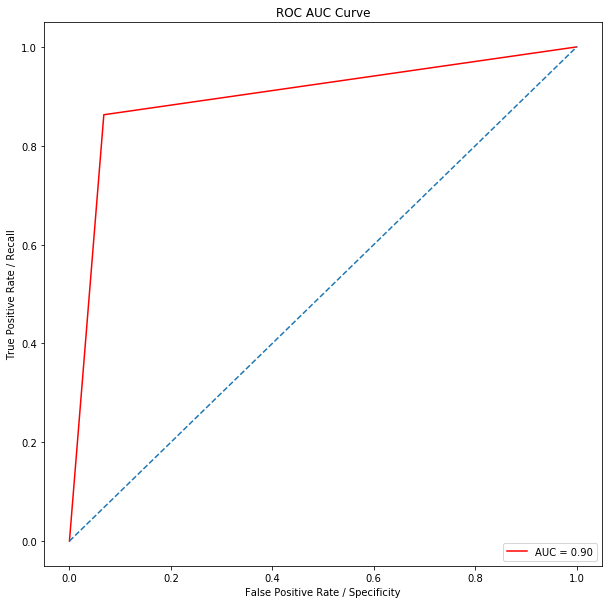

In [106]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predict)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure(figsize=(10,10))
plt.title('ROC AUC Curve')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate / Recall')
plt.xlabel('False Positive Rate / Specificity')
plt.show()

### Conclusion

The downsampling of the negative class improved the AUC Curve lot bettter. 
The AUC improved from .67 to .90 which is a big improvement and the MSE decreased. 

The accuracy of the model decreased however because the proprtion of people who recovered really increased.

Here for example: 

## B. Better managing missing values